In [2]:
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 3.6 MB/s eta 0:00:01       | 3.3 MB 3.6 MB/s eta 0:00:02
     |████████████████████████████████| 233 kB 11.1 MB/s eta 0:00:01


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from src import config

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [158]:
def mape(test_data, forecast_data):
    return np.where(test_data != 0,
                    abs(test_data.reset_index(drop=True) - forecast_data.reset_index(drop=True))/test_data.reset_index(drop=True),
                    np.where(forecast_data != 0, 1, 0)).mean()

In [192]:
def minHWM(df):
    train_size = int(len(df)*0.8)
    df_train, df_test = df[0:train_size], df[train_size:]
    test_index = test.index
    
    df_train_clean = df_train.copy()
    rep_index = df_train_clean[df_train_clean['order_total_price']==0].index
    df_train_clean.loc[rep_index, 'order_total_price'] = 1
    
    cols = df_train.columns
    HWM_table = pd.DataFrame(columns=cols, index=test_index)

    for col in cols:
        HWM1 = ExponentialSmoothing(
            df_train_clean[col],
            seasonal_periods=4,
            trend="add",
            seasonal="add",
            use_boxcox=True,
            initialization_method="estimated",
        ).fit()

        HWM2 = ExponentialSmoothing(
            df_train_clean[col],
            seasonal_periods=4,
            trend="add",
            seasonal="mul",
            use_boxcox=True,
            initialization_method="estimated",
        ).fit()

        HWM3 = ExponentialSmoothing(
            df_train_clean[col],
            seasonal_periods=4,
            trend="add",
            seasonal="add",
            damped_trend=True,
            use_boxcox=True,
            initialization_method="estimated",
        ).fit()

        HWM4 = ExponentialSmoothing(
            df_train_clean[col],
            seasonal_periods=4,
            trend="add",
            seasonal="mul",
            damped_trend=True,
            use_boxcox=True,
            initialization_method="estimated",
        ).fit()

        fcastHWM1 = HWM1.forecast(len(df_test)).rename("Holt's Winters additive trend")
        fcastHWM2 = HWM2.forecast(len(df_test)).rename("Holt's Winters multiplicative trend")
        fcastHWM3 = HWM3.forecast(len(df_test)).rename("Holt's Winters additive damped trend")
        fcastHWM4 = HWM4.forecast(len(df_test)).rename("Holt's Winters multiplicative damped trend")


        # Find lowest MAPE from the 4 HWM models
        min_mape = np.inf
        min_HWM = pd.DataFrame()
        for HWM in [fcastHWM1, fcastHWM2, fcastHWM3, fcastHWM4]:
            cur_mape = mape(df_test[col], HWM)
            if cur_mape < min_mape:
                min_mape = cur_mape
                min_HWM = pd.DataFrame(HWM)
                min_model = HWM.name

        HWM_table[col] = min_HWM
        print('Best Model is: ', min_model)
        print('MAPE: ', min_mape)
        
    return HWM_table

In [6]:
df = pd.read_parquet(config.INT_FILE_PATH / 'transactions.parquet')

In [7]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name,order_total_price,shipping_cost_perc,purchase_dow,late_delivery,delivery_days,days_late,product_size
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture,146.87,0.148975,1,False,8.0,0.0,107136.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,housewares,335.48,0.138548,4,False,16.0,0.0,53400.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,office_furniture,157.73,0.112788,5,True,26.0,1.0,45968.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,office_furniture,173.30,0.134795,1,False,14.0,0.0,79968.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,home_confort,252.25,0.088206,6,False,11.0,0.0,23625.0


In [8]:
df2 = df[["order_purchase_timestamp", "order_total_price"]]

In [9]:
weekly_sales = df.set_index("order_purchase_timestamp").resample("W")[["order_total_price"]].sum()

In [58]:
# Remove the last few weeks with small values)
weekly_sales_clean = weekly_sales[:-8]

In [193]:
minHWM(weekly_sales_clean)

Best Model is:  Holt's Winters additive damped trend
MAPE:  0.23967422481122544


,order_total_price
order_purchase_timestamp,
2018-04-08,235060.484172
2018-04-15,244498.643648
2018-04-22,255021.132366
2018-04-29,259158.108033
2018-05-06,249144.683255
2018-05-13,258696.931020
2018-05-20,269360.601200
2018-05-27,273396.074222
2018-06-03,262778.541169


## Code below is for Visualization of above MinHWM function

In [61]:
train_size = int(len(weekly_sales_clean)*0.8)

In [66]:
train, test = weekly_sales_clean[0:train_size], weekly_sales_clean[train_size:]

In [67]:
train.columns

Index(['order_total_price'], dtype='object')

In [68]:
train.shape

(83, 1)

In [69]:
test.shape

(21, 1)

## Replace 0 value with small value (1 for this case)

In [143]:
train[train['order_total_price']==0].index

DatetimeIndex(['2016-09-25', '2016-10-23', '2016-10-30', '2016-11-06',
               '2016-11-13', '2016-11-20', '2016-11-27', '2016-12-04',
               '2016-12-11', '2016-12-18', '2017-01-01'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', freq=None)

In [144]:
train_clean = train.copy()
rep_index = train_clean[train_clean['order_total_price']==0].index
train_clean.loc[rep_index, 'order_total_price'] = 1

## HWM Additive Trend

In [145]:
HWM1 = ExponentialSmoothing(
    train_clean['order_total_price'],
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [202]:
fcastHWM1 = HWM1.forecast(21).rename("Holt's Winters additive trend")

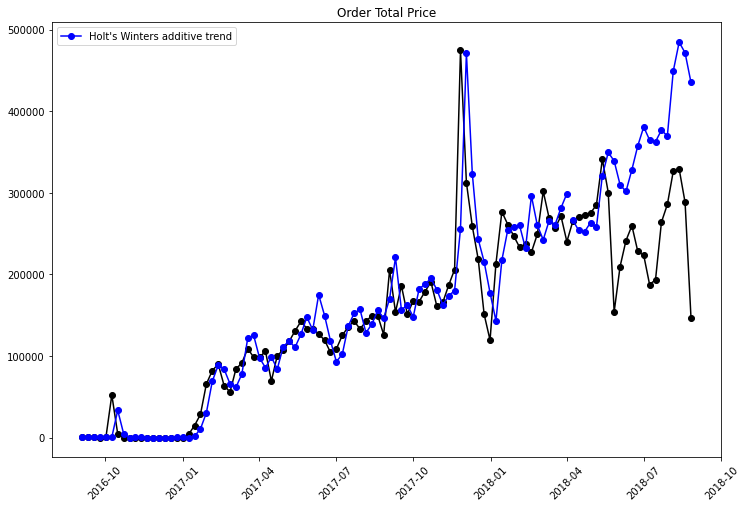

In [203]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Order Total Price')
plt.plot(weekly_sales_clean['order_total_price'], marker="o", color="black")
plt.plot(HWM1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcastHWM1, marker="o", color="blue")
plt.legend([line1],[fcastHWM1.name])

In [ ]:
mape(test['order_total_price'], fcastHWM1)

0.47433590016390037

## HWM Multiplicative Trend

In [148]:
HWM2 = ExponentialSmoothing(
    train_clean['order_total_price'],
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [149]:
fcastHWM2 = HWM2.forecast(21).rename("Holt's Winters additive trend")

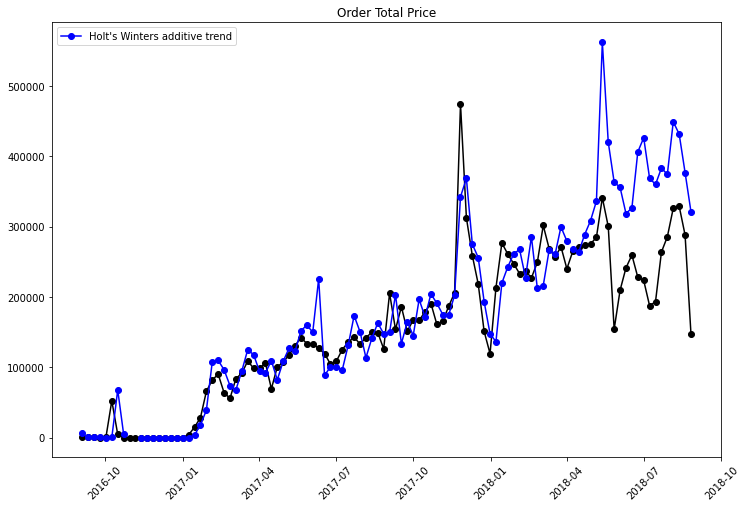

In [150]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Order Total Price')
plt.plot(weekly_sales_clean['order_total_price'], marker="o", color="black")
plt.plot(HWM2.fittedvalues, marker="o", color="blue")
(line2,) = plt.plot(fcastHWM2, marker="o", color="blue")
plt.legend([line2],[fcastHWM2.name])

In [169]:
mape(test['order_total_price'], fcastHWM2)

0.5020251856659874

## HWM Additive with Damped Trend

In [151]:
HWM3 = ExponentialSmoothing(
    train_clean['order_total_price'],
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [209]:
fcastHWM3 = HWM3.forecast(50).rename("Holt's Winters additive damped trend")

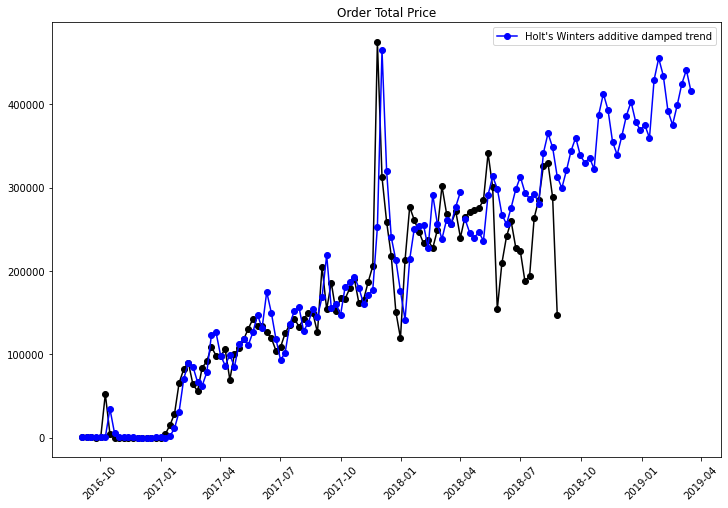

In [210]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Order Total Price')
plt.plot(weekly_sales_clean['order_total_price'], marker="o", color="black")
plt.plot(HWM3.fittedvalues, marker="o", color="blue")
(line3,) = plt.plot(fcastHWM3, marker="o", color="blue")
plt.legend([line3],[fcastHWM3.name])

In [168]:
mape(test['order_total_price'], fcastHWM3)

0.25759913709135696

## HWM Multiplicative with Damped Trend

In [154]:
HWM4 = ExponentialSmoothing(
    train_clean['order_total_price'],
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [155]:
fcastHWM4 = HWM4.forecast(21).rename("Holt's Winters multiplicative damped trend")

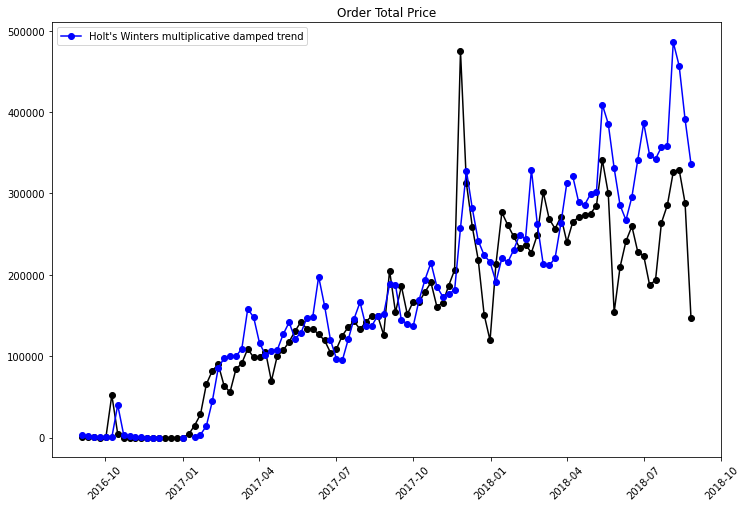

In [156]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Order Total Price')
plt.plot(weekly_sales_clean['order_total_price'], marker="o", color="black")
plt.plot(HWM4.fittedvalues, marker="o", color="blue")
(line4,) = plt.plot(fcastHWM4, marker="o", color="blue")
plt.legend([line4],[fcastHWM4.name])

In [167]:
mape(test['order_total_price'], fcastHWM4)

0.41392402548905227